# Assignment 6.12 - Womanium 2024
***Leonidas Zimianitis***

# Quantum Walk on a Line with 16 Nodes: Implementation and Explanation

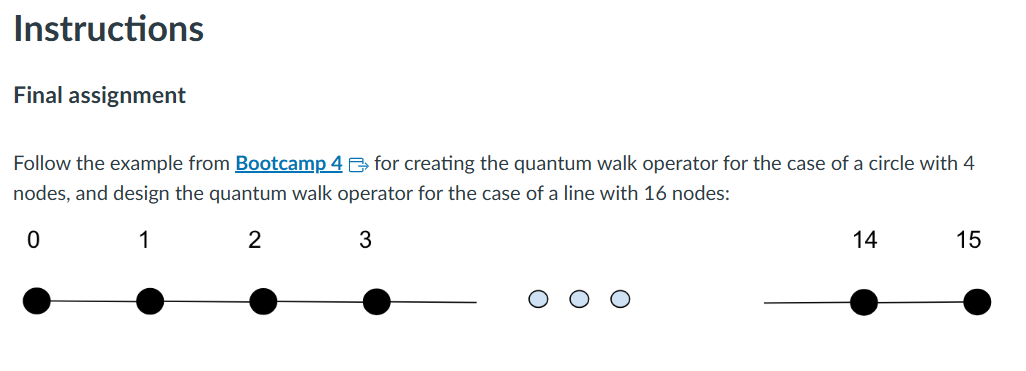

In [1]:
from IPython.display import Image
Image("6.12_instructions.png")

## Introduction

This document explains the implementation of a quantum walk on a line with 16 nodes using the Classiq framework. The goal is to design and implement quantum operators, particularly focusing on the discrete-time quantum walk framework. The explanation is based on a concrete example and is structured into chapters covering key aspects of the implementation.

## Quantum Walk Basics

A quantum walk is a quantum analog of a classical random walk. It involves moving a quantum state across a graph's vertices according to quantum mechanical rules. In this example, we focus on a line graph with 16 nodes, where each node can be connected to its neighboring nodes.

### Graph Representation

The graph consists of 16 nodes labeled from 0 to 15. The edges connect each node to its immediate neighbors, with the graph forming a line.

### Discrete-Time Quantum Walk

In discrete-time quantum walks, the evolution of the quantum state is governed by applying a unitary operator repeatedly. This operator is typically a combination of two sub-operators: the coin operator (C) and the shift operator (S).


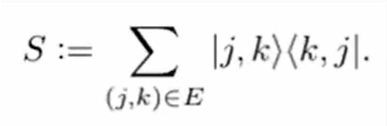

In [2]:
Image("shift_operator.png")

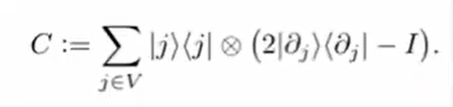

In [3]:
Image("coin_operator.png")


## Encoding Quantum States

### Vertex Encoding

Vertices in the graph are encoded as quantum states using a quantum register called `vertices`. The state of this register represents the position of the walker in the graph. For 16 nodes, we use a 4-qubit register, as \(2^4 = 16\).


### Adjacent Vertices Encoding
In addition to the main vertices, we need to encode adjacent vertices. This is achieved by using another quantum register called adjacent_vertices. The state of this register indicates the possible positions the walker can move to next.

# The Shift Operator (S)

## Edge Oracle
An edge oracle is used to determine if two vertices are connected. For our specific graph, the oracle checks if the sum of the vertices is equal to '1', indicating an edge. **We raise the result to the power of two. This way we secure that our result is positive. We also take advantage of the property that as many times as you multiply '1' by itself, you will be getting the same result; that of '1'.**

```python
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= ((((vertices - adjacent_vertices)**2) == 1))
```

## Bitwise Swap
The bitwise swap operation exchanges the states of the vertices and adjacent_vertices registers if they are connected by an edge, as determined by the edge oracle.

```python
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
```

## Applying the Shift Operator
The S_operator function applies the bitwise swap operation to all vertex states that have an adjacent vertex connected by an edge.

```python
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
    operand=lambda: bitwise_swap(vertices, adjacent_vertices))
```

# The Walk Operator (W)
## Probability Vector Initialization
For the quantum walk, we define a probability vector that determines the likelihood of the walker moving to each possible neighboring vertex. The W_iteration function sets up this probability distribution. **If 'i' is the first or the last node, then to avoid stepping out of the array, we either move to the next node, or the last one respectively.**

```python
def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0] * 16
    if i == 0:  # First node
        prob[1] = 1.0
    elif i == 15:  # Last node
        prob[14] = 1.0 
    else:
        prob[i + 1] = 0.5
        prob[i - 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices == i,
            operand=lambda: within_apply(
              compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action=lambda: zero_diffuzer(adjacent_vertices)))
```

## Applying the Walk Operator
The W_operator function iterates over all possible vertex states and applies the W_iteration for each state. This operator introduces superposition into the walker's state, allowing it to explore multiple paths simultaneously.

```python
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)
```

# Implementation Details and Execution Results
## Main Function
The main function initializes the quantum registers, applies a Hadamard transform to put the vertices register in superposition, and sequentially applies the W_operator and S_operator.

```python
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)
```

## Implementation

In [4]:
from classiq import *

size = 4  # Adjust size for 16 nodes

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0] * 16
    if i == 0:  # First node
        prob[1] = 1.0
    elif i == 15:  # Last node
        prob[14] = 1.0
    else:
        prob[i + 1] = 0.5
        prob[i - 1] = 0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices == i,
            operand=lambda: within_apply(
              compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action=lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= ((((vertices - adjacent_vertices)**2) == 1))
@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
    operand=lambda: bitwise_swap(vertices, adjacent_vertices))

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)


State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

The current version of 'classiq' has been deprecated, and will not be supported as of 2024-07-27. Please run "pip install -U classiq" to upgrade the classiq SDK to the latest version.


Opening: https://platform.classiq.io/circuit/16c5a7ad-c16e-44b0-9fec-28ad84af1d68?version=0.42.2


## Execution Results
Below we present the results of our execution. ***!!!Disclaimer!!: There are no execution results as the program could not run due to the high number of qubits, so we will just stick to inspecting the circuit instead!***

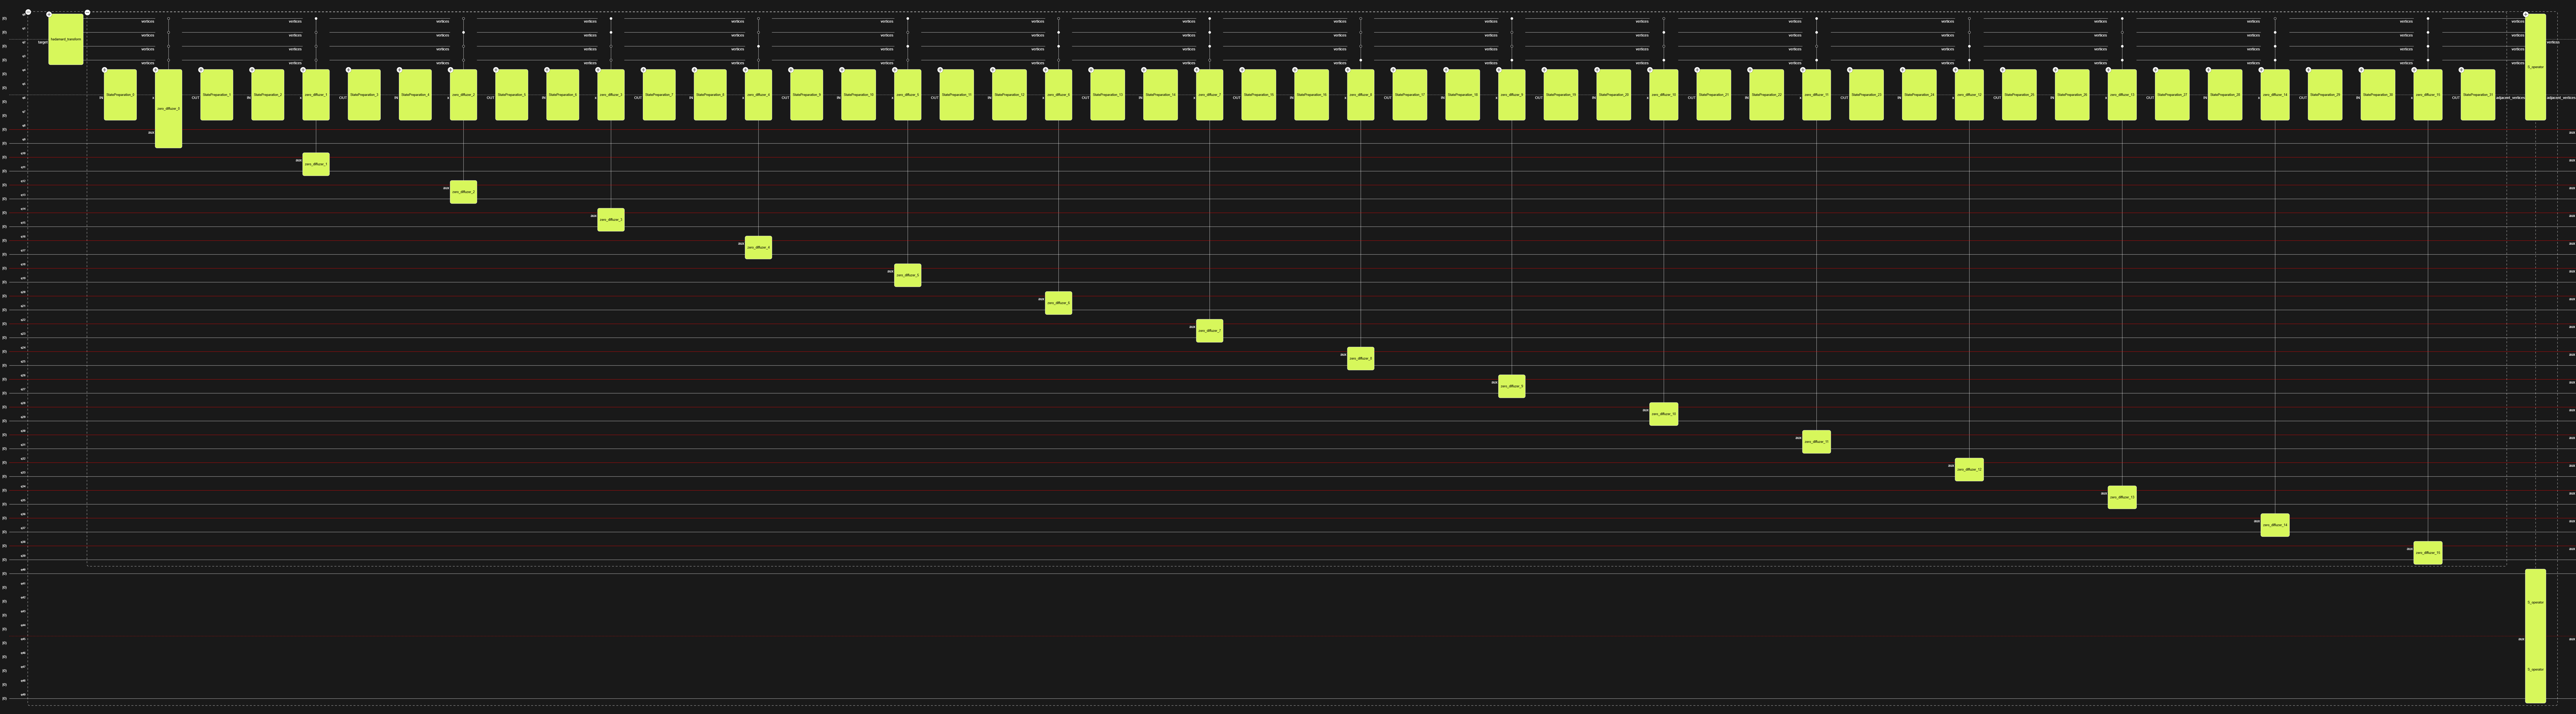

In [5]:
Image("circuit_screenshot.jpg")

### A closer look!

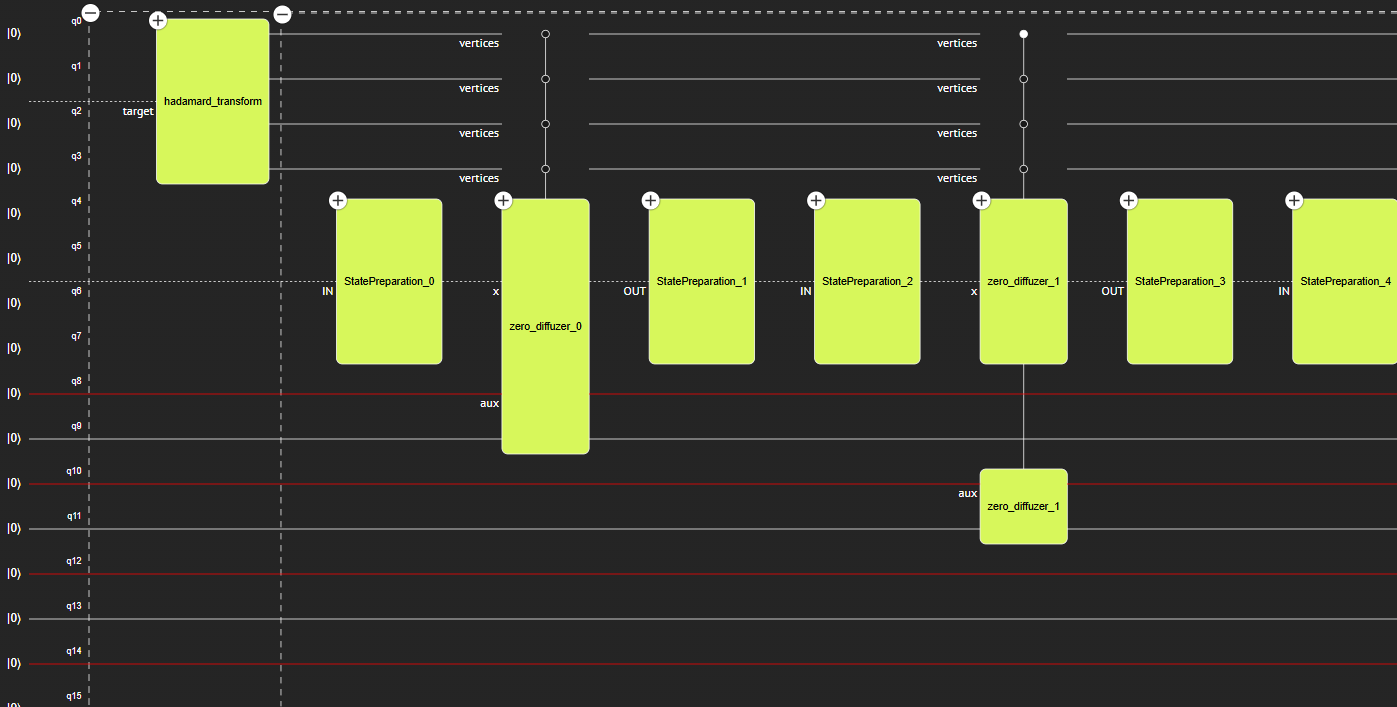

In [6]:
Image("circuit_screenshot_zoom1.jpg.png")

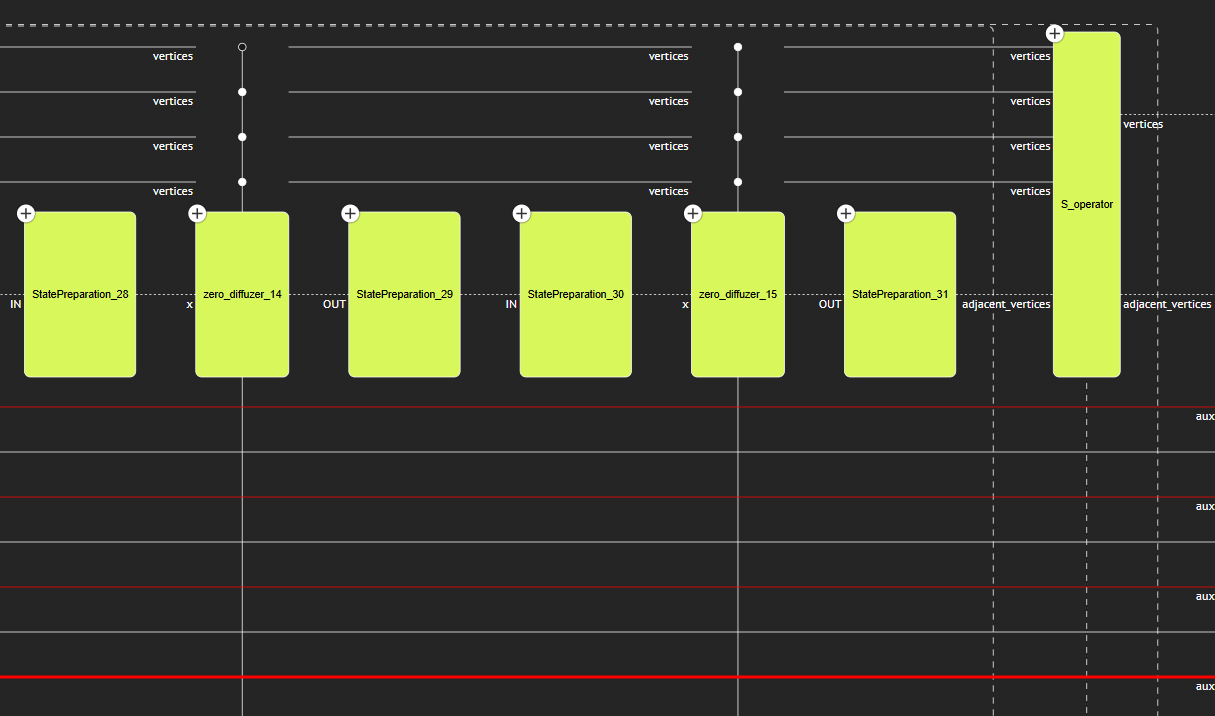

In [7]:
Image("circuit_screenshot_zoom2.jpg.png")

### Conclusions

- Visual Cues and Structure:
    - Vertical Lines: Each vertical line connecting the gates represents a single qubit or a quantum register. The alignment of operations across these lines indicates the application of gates to specific qubits or control operations conditioned on the states of other qubits.
    - Controlled Operations: The connected dots (with vertical lines linking gates on different qubits) indicate controlled operations, where an operation on one qubit is conditioned on the state of another.

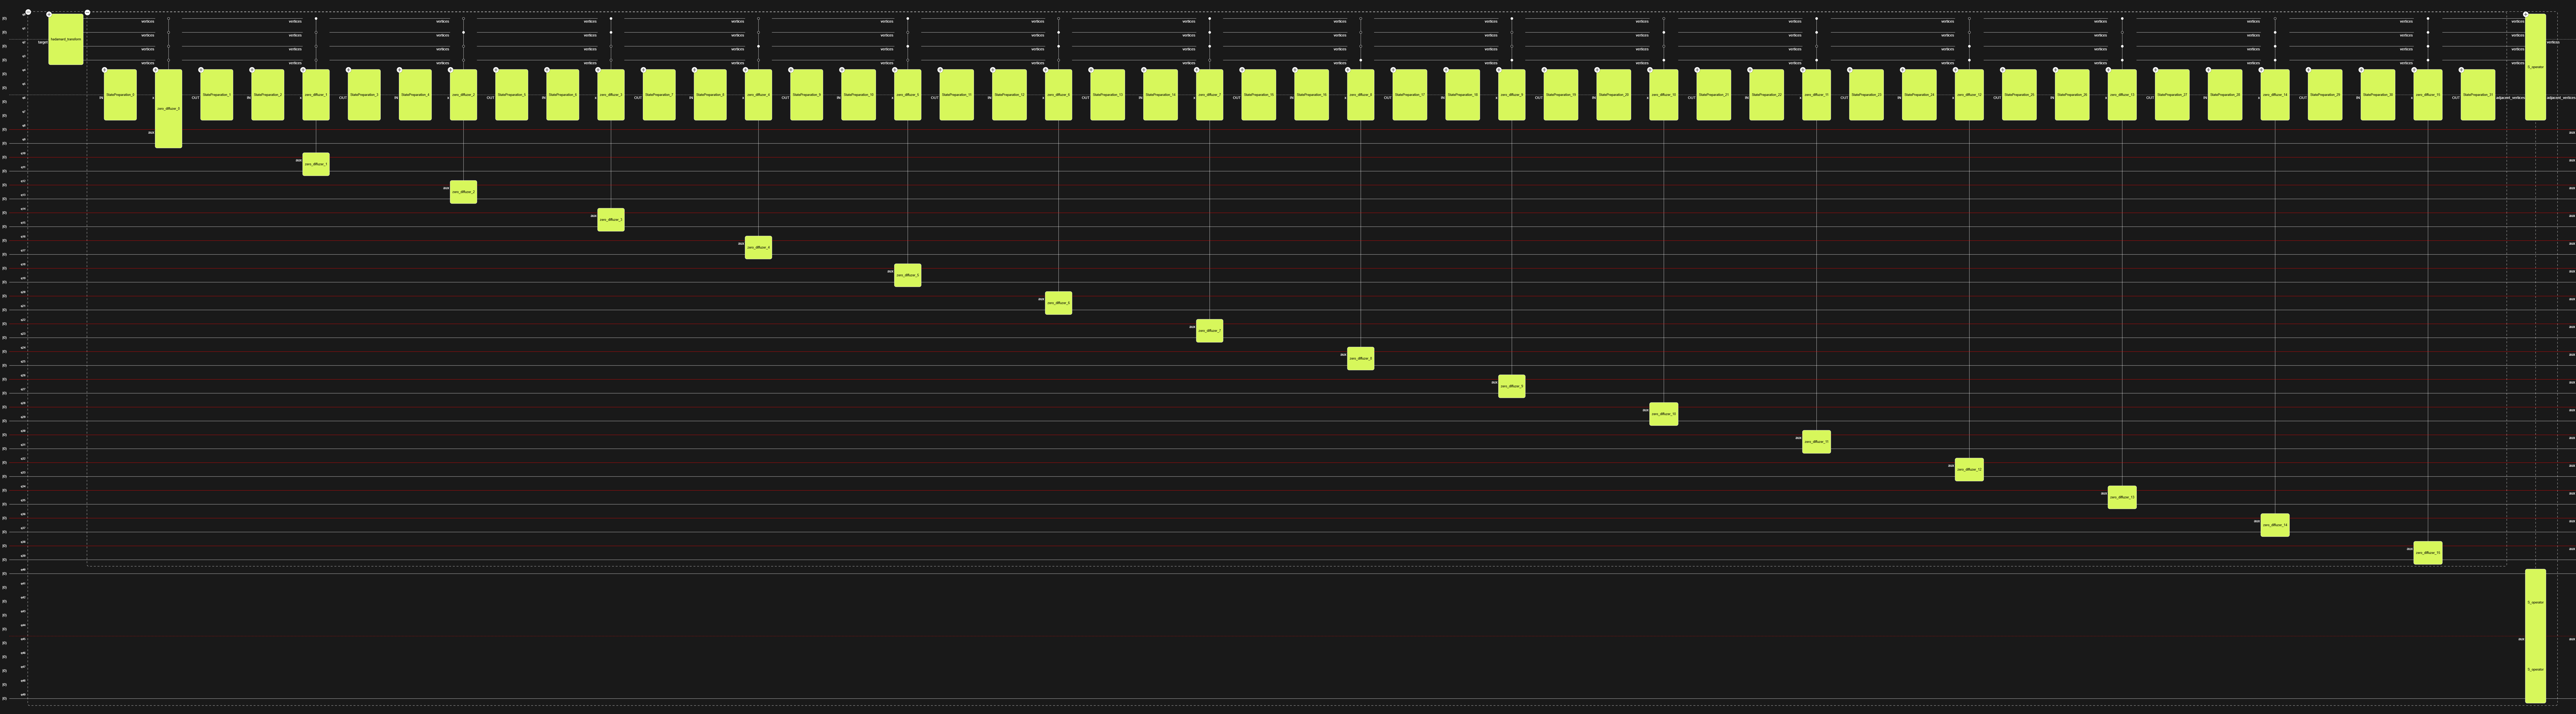

In [8]:
Image("circuit_screenshot.jpg")

The quantum circuit diagram provided represents the implementation of a quantum walk on a line graph with 16 nodes. Here's a detailed description of the key components and their organization:

**1. Initialization Stage**
Hadamard Gates (H): The topmost row consists of Hadamard gates applied to each of the qubits. These gates are applied to initialize the walker in a superposition of all possible positions on the line, preparing the quantum state for the walk. Each yellow box in this row represents a Hadamard gate.

**2. Walk Operator (W) and Coin Flip**
Controlled Gates: The next few rows after the Hadamards appear to have controlled operations. These might involve conditional operations like controlled-U or other unitary operations that prepare the walker's state based on adjacent vertices. The controlled gates are likely used to set up the transition amplitudes based on the probabilities associated with the walk.

**3. Edge Oracle and Conditional Operations**
Conditional Operations: The descending sequence of yellow boxes further along the circuit indicates conditional operations, involving checks for edges between vertices. This could represent the application of the edge oracle, which determines if two vertices are connected. These operations conditionally apply further unitary transformations depending on whether an edge exists between nodes.

**4. Shift Operator (S)**
Bitwise Swap or Shift Operations: The diagonal alignment of the gates suggests a systematic operation applied across the qubits, bitwise swaps or shifts between vertices and adjacent_vertices. These operations effectively move the quantum state, representing the walker, according to the defined quantum walk rules.

**5. Measurement**
Final Measurements: The final stage, indicated by the last column of gates, represents measurement operations. These measurements collapse the superposition of quantum states into a definite state, giving a classical outcome that indicates the walker's position on the line.